# Scattering Function Normalization

**Scott Prahl**

**Feb 2025**

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "emscripten":
    import piplite

    await piplite.install("miepython", deps=False)
    os.environ["MIEPYTHON_USE_JIT"] = "0"  # jupyterlite cannot use numba

import miepython as mie

## Solid Angles

Solid angles are the 3D analog of 2D angles.  A radian $\theta$ is defined as the angle represented by an arc length on circle divided by the radius $R$ of the circle

$$
\theta = \frac{\mbox{arc length}}{R}
$$

A steradian $\Omega$ is defined as the area on a surface of a sphere divided by the square of its radius $R$.  

$$
\Omega = \frac{\mbox{surface area}}{R^2}
$$

Thus the total number of steradians in a sphere is $4\pi R^2/R^2=4\pi$

For example usage, a circular detector (pointed at the center) with radius $r_d$ at a distance $R$  from the center will subtend an approximate angle (the detector is flat and does not curve with the sphere surface)

$$
\Omega \approx \frac{\pi r_d^2}{R^2}
$$

(assuming $r_d\ll R$). Now if $P_0$ of light is scattered by a sphere located at the center then the scattered power on the detector will be

$$
P_d = P_0 \cdot \Omega \cdot p(\mu)
$$

where $\mu$ is the cosine of the angle between the incoming light and a ray to the center of the detector.

## Normalization of the scattered light

Mie scattering is used in a wide variety of disciplines to describe the scattering pattern from spheres.  Not surprisingly a bunch of different normalizations have arisen that can be described based on the integrating the scattering function over all directions ($4\pi$ steradians).

Integrating the scattering phase function all solid angles suggests the following dimensionless possibilities which have been chosen by one or more authors for their convenience.  `miepython` supports all of these.

$$
\begin{align}
\int_{4\pi} p(\theta,\phi) \,d\Omega = a       \qquad&\qquad \mbox{albedo (default)}\\[2mm]
\int_{4\pi} p(\theta,\phi) \,d\Omega = 1       \qquad&\qquad \mbox{one}\\[2mm]
\int_{4\pi} p(\theta,\phi) \,d\Omega = 4\pi    \qquad&\qquad \mbox{4pi}\\[2mm]
\int_{4\pi} p(\theta,\phi) \,d\Omega = Q_{sca} \qquad&\qquad \mbox{qsca}\\[2mm]
\int_{4\pi} p(\theta,\phi) \,d\Omega = Q_{ext} \qquad&\qquad \mbox{qext}\\[2mm]
\int_{4\pi} p(\theta,\phi) \,d\Omega = 4\pi x^2 Q_{sca}\qquad&\qquad \mbox{Bohren}\\[2mm]
\int_{4\pi} p(\theta,\phi) \,d\Omega =\pi x^2 Q_{sca}\qquad&\qquad \mbox{Wiscombe}\\[2mm]
\end{align}
$$

where $x=2\pi a/\lambda$ is the size parameter of a sphere with radius $a$ at wavelength $\lambda$.

The single scattering albedo is $a$, defined as

$$
a = \frac{Q_\mathrm{sca}}{Q_\mathrm{ext}} = \frac{Q_\mathrm{sca}}{Q_\mathrm{sca}+Q_\mathrm{abs}}
$$

and $Q_\mathrm{sca}$, $Q_\mathrm{ext}$, and $Q_\mathrm{abs}$ are the scattering, extinction, and absorption efficiencies.

## Verifying normalization

Since  $d\Omega=\sin\theta d\theta\,d\phi$ is a differential solid angle, the integral of the scattering phase function over all solid angles is

$$
\mbox{total} = \int_{4\pi} \, p(\Omega)\,d\Omega \equiv \int_0^{2\pi}\int_0^\pi \, p(\theta,\phi)\,\sin\theta\,d\theta\,d\phi
$$

or with a change of variables $\mu=\cos\theta$ and using symmetry (the phase function is independent of $\phi$), the integral simplifies to

$$
\mbox{total} = 2\pi \int_{-1}^1 \, p(\mu)\,d\mu
$$

This integral can be done numerically by simply summing all the rectangles

$$
\mbox{total} = 2\pi \sum_{i=0}^N p(\mu_i)\,\Delta\mu_i
$$

which can be found using `np.trapz()`

## Phase Functions

### Case 1. n=1.5, x=1

For this non-strongly peaked scattering function, the simple integration remains close to the expected value.

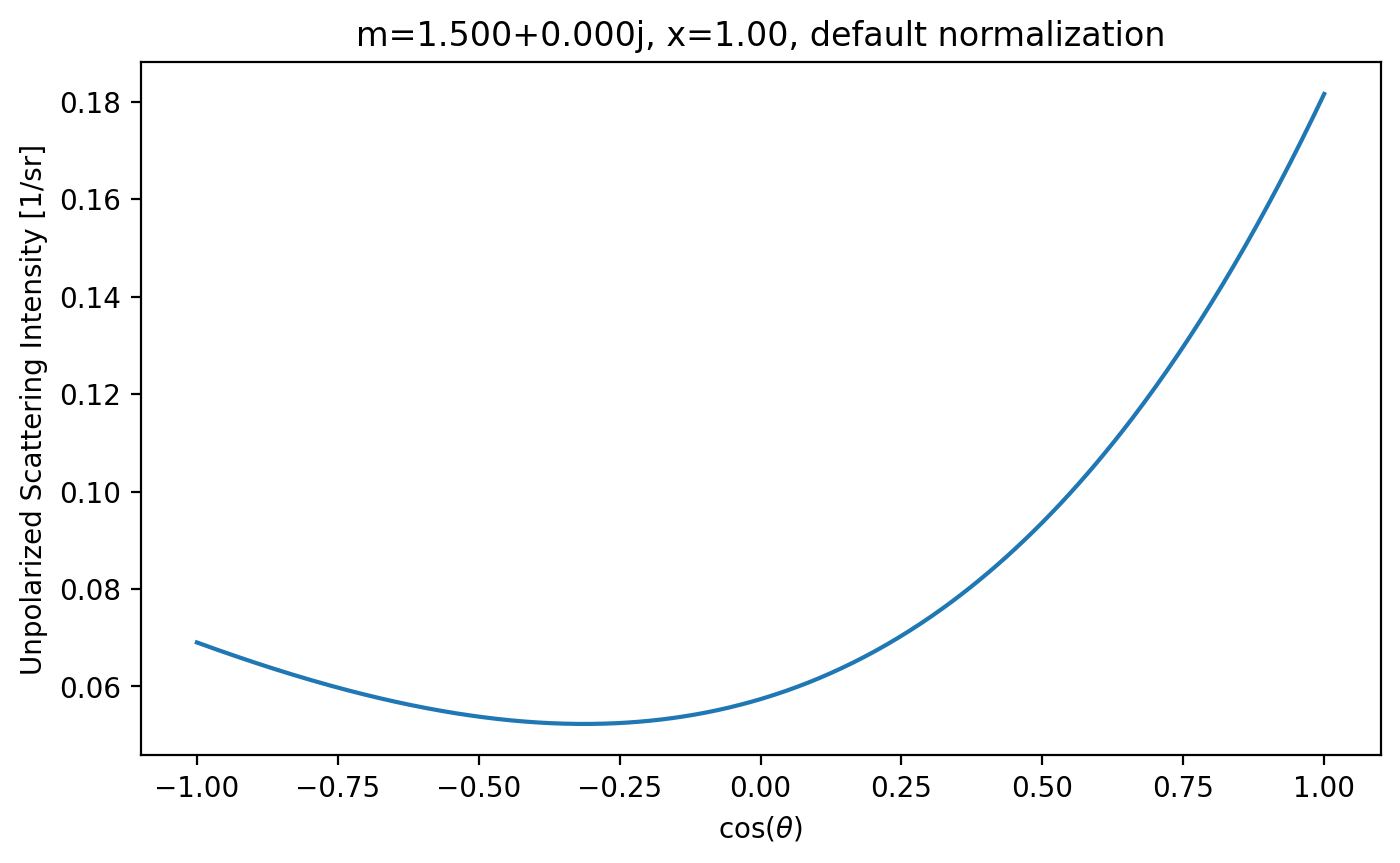

 Normalization    Total  Expected
        albedo    1.000     1.000
           one    1.000     1.000
           4pi   12.566    12.566
          qsca    0.215     0.215
          qext    0.215     0.215
        bohren    2.703     2.703
      wiscombe    0.676     0.676


In [2]:
m = 1.5
x = 1
mu = np.linspace(-1, 1, 501)
intensity = mie.i_unpolarized(m, x, mu)
qext, qsca, qback, g = mie.efficiencies_mx(m, x)

norms = ["albedo", "one", "4pi", "qsca", "qext", "bohren", "wiscombe"]
expected = [
    qsca / qext,
    1.0,
    4 * np.pi,
    qsca,
    qext,
    4 * np.pi * x**2 * qsca,
    np.pi * x**2 * qsca,
]

plt.plot(mu, intensity)
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Unpolarized Scattering Intensity [1/sr]")
plt.title("m=%.3f%+.3fj, x=%.2f, default normalization" % (m.real, m.imag, x))
plt.show()


print(" Normalization    Total  Expected")

for i, norm in enumerate(norms):

    intensity = mie.i_unpolarized(m, x, mu, norm)
    total = 2 * np.pi * np.trapezoid(intensity, mu)
    print("%14s %8.3f  %8.3f" % (norm, total, expected[i]))

### Case 2: m=1.5-1.5j, x=1

For this non-strongly peaked scattering function, the simple integration remains close to the expected value.

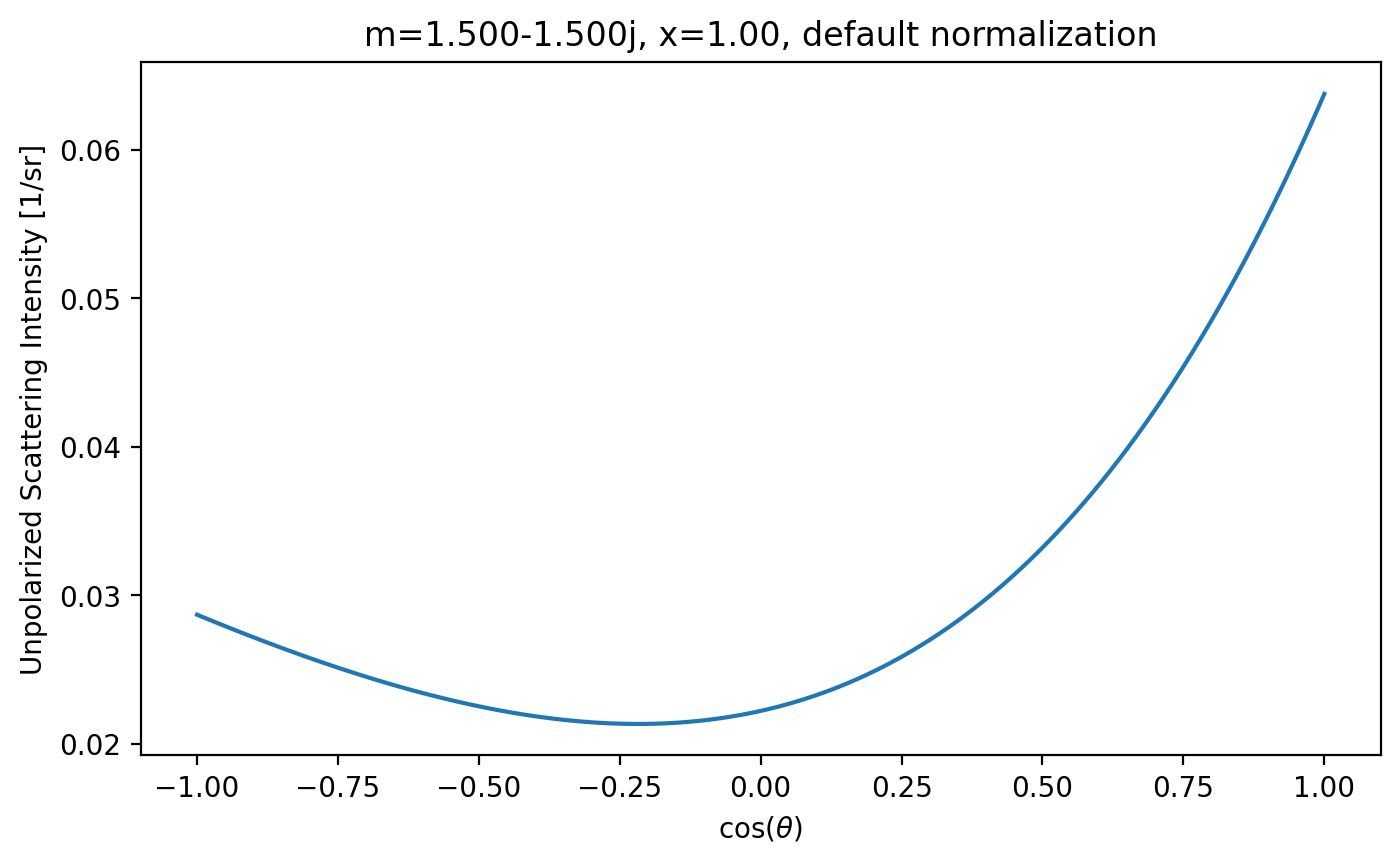

 Normalization    Total  Expected
        albedo    0.377     0.377
           one    1.000     1.000
           4pi   12.566    12.566
          qsca    1.139     1.139
          qext    3.023     3.023
        bohren   14.308    14.308
      wiscombe    3.577     3.577


In [3]:
m = 1.5 - 1.5j
x = 1
mu = np.linspace(-1, 1, 501)
intensity = mie.i_unpolarized(m, x, mu)
qext, qsca, qback, g = mie.efficiencies_mx(m, x)

norms = ["albedo", "one", "4pi", "qsca", "qext", "bohren", "wiscombe"]
expected = [
    qsca / qext,
    1.0,
    4 * np.pi,
    qsca,
    qext,
    4 * np.pi * x**2 * qsca,
    np.pi * x**2 * qsca,
]

plt.plot(mu, intensity)
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Unpolarized Scattering Intensity [1/sr]")
plt.title("m=%.3f%+.3fj, x=%.2f, default normalization" % (m.real, m.imag, x))
plt.show()

print(" Normalization    Total  Expected")

for i, norm in enumerate(norms):

    intensity = mie.i_unpolarized(m, x, mu, norm)
    total = 2 * np.pi * np.trapezoid(intensity, mu)
    print("%14s %8.3f  %8.3f" % (norm, total, expected[i]))

## Case III, evenly spaced $\theta$

For this non-strongly peaked scattering function, even spacing in $\theta$ improves the accuracy of the integration.

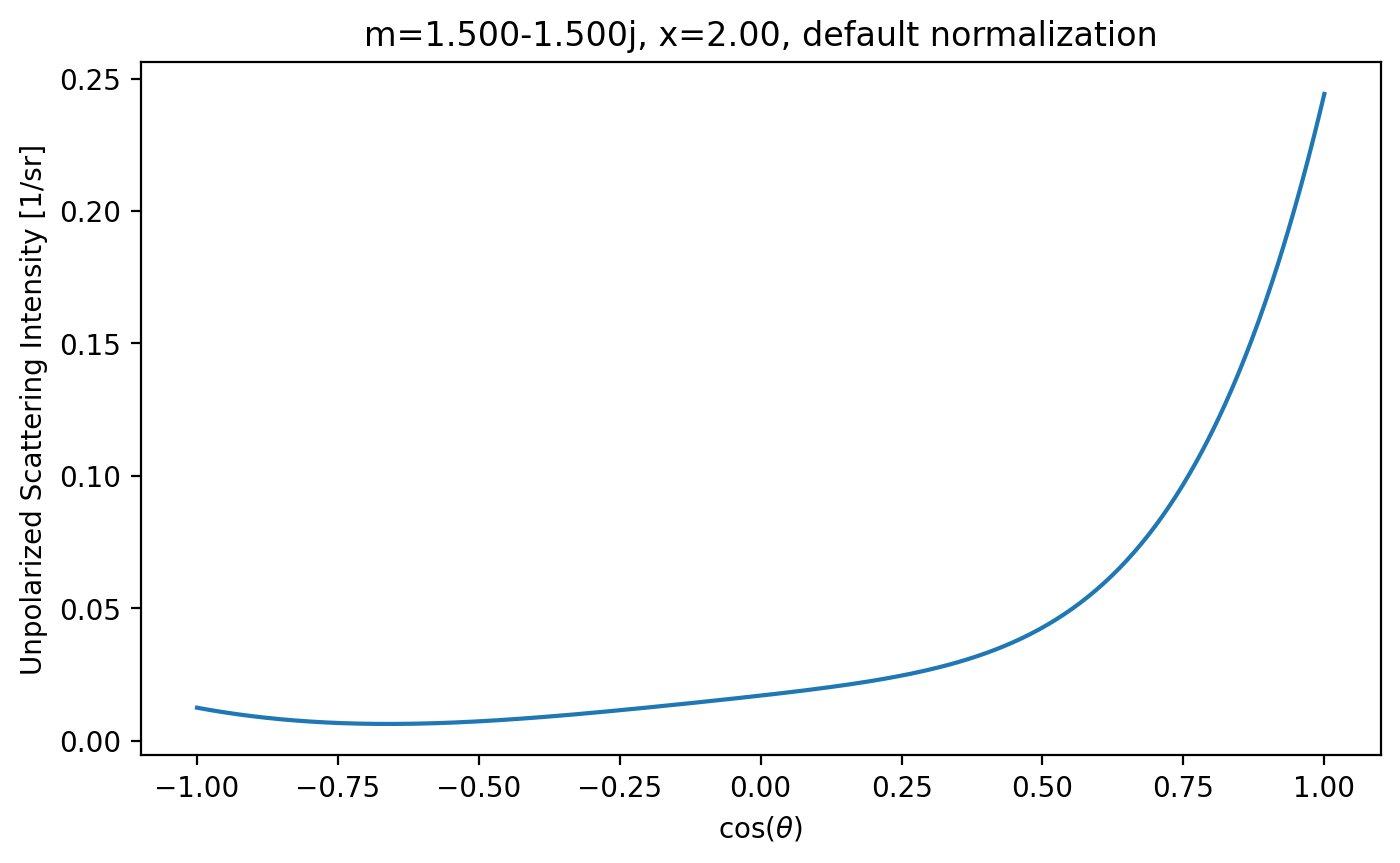

 Normalization    Total  Expected
        albedo    0.496     0.496
           one    1.000     1.000
           4pi   12.567    12.566
          qsca    1.523     1.523
          qext    3.069     3.068
        bohren   76.579    76.576
      wiscombe   19.145    19.144


In [4]:
m = 1.5 - 1.5j
x = 2
theta = np.linspace(np.pi, 0, 361)
mu = np.cos(theta)

intensity = mie.i_unpolarized(m, x, mu)
qext, qsca, qback, g = mie.efficiencies_mx(m, x)

norms = ["albedo", "one", "4pi", "qsca", "qext", "bohren", "wiscombe"]
expected = [
    qsca / qext,
    1.0,
    4 * np.pi,
    qsca,
    qext,
    4 * np.pi * x**2 * qsca,
    np.pi * x**2 * qsca,
]

plt.plot(mu, intensity)
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Unpolarized Scattering Intensity [1/sr]")
plt.title("m=%.3f%+.3fj, x=%.2f, default normalization" % (m.real, m.imag, x))
plt.show()

print(" Normalization    Total  Expected")

for i, norm in enumerate(norms):

    intensity = mie.i_unpolarized(m, x, mu, norm)
    total = 2 * np.pi * np.trapezoid(intensity, mu)
    print("%14s %8.3f  %8.3f" % (norm, total, expected[i]))

## Differential Scattering Cross Section

The *differential scattering cross section* $\frac{d\sigma_{sca}}{d\Omega}$ is defined in terms of the total scattering cross section

$$
\sigma_\mathrm{sca} = \pi r^2 Q_\mathrm{sca} = \int_{4\pi} \frac{d\sigma_{sca}}{d\Omega}\,d\Omega
$$

Thus if the unpolarized scattering is normalized so its integral is the scattering efficiency

$$
Q_\mathrm{sca} = \int_{4\pi} p(\mu) \,d\Omega
$$

then

$$
\frac{d\sigma_{sca}}{d\Omega} = \pi r^2 p(\theta,\phi)
$$ 

The differential scattering cross section can be obtained `miepython` by normalizing to `qsca` and multiplying the result by the geometric cross section 

    diff_sca = np.pi * r**2 * mie.i_unpolarized(m,x,mu,norm='qsca')

For example, here is a replica of [figure 4](http://plaza.ufl.edu/dwhahn/Rayleigh%20and%20Mie%20Light%20Scattering.pdf)

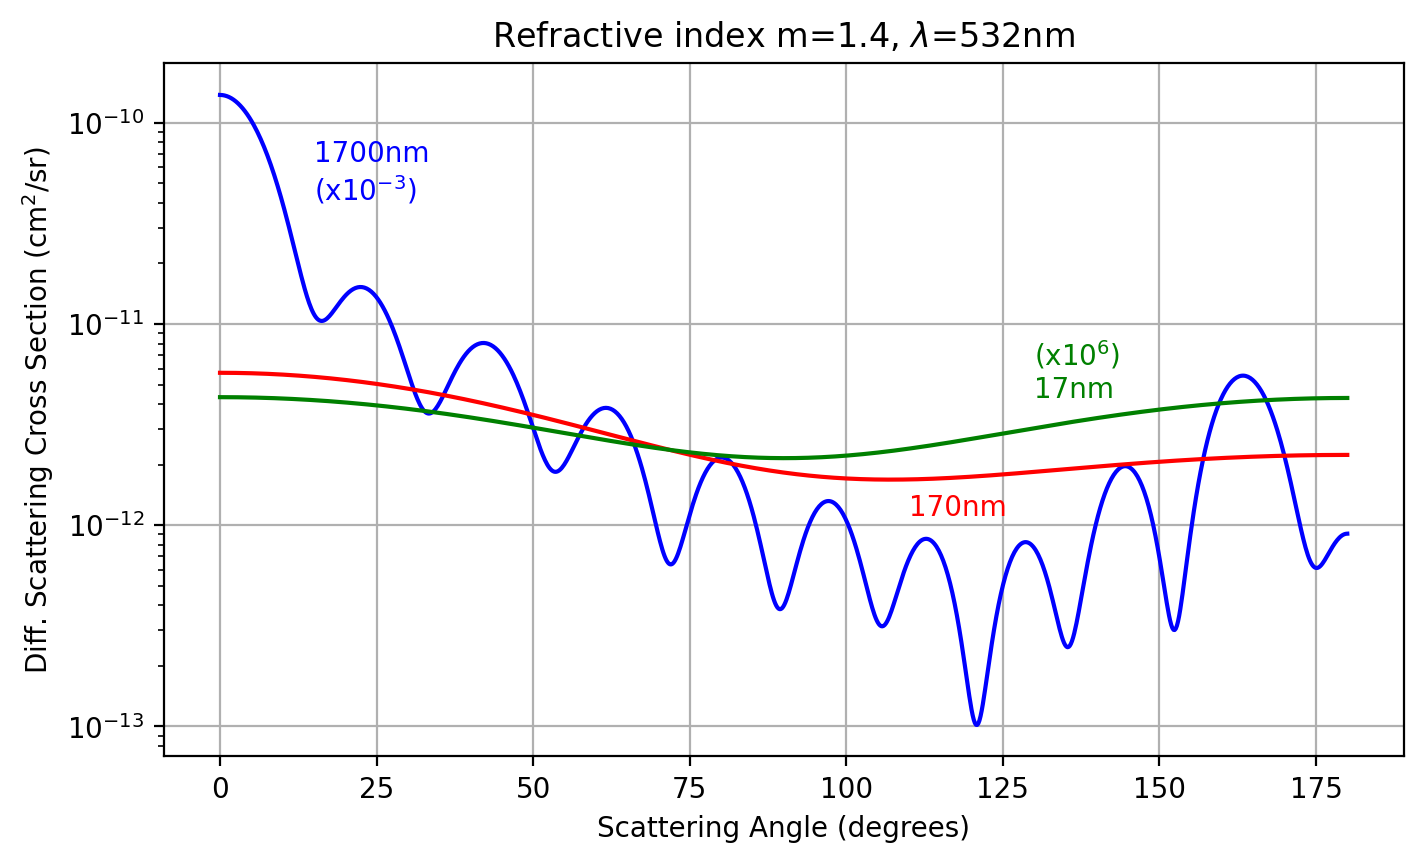

In [5]:
m = 1.4 - 0j
lambda0 = 532e-9  # m
theta = np.linspace(0, 180, 1000)
mu = np.cos(theta * np.pi / 180)

d = 1700e-9  # m
x = 2 * np.pi / lambda0 * d / 2
geometric_cross_section = np.pi * d**2 / 4 * 1e4  # cm**2
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
sigma_sca = geometric_cross_section * mie.i_unpolarized(m, x, mu, "qsca")
plt.semilogy(theta, sigma_sca * 1e-3, color="blue")
plt.text(15, sigma_sca[0] * 3e-4, "%.0fnm\n(x10$^{-3}$)" % (d * 1e9), color="blue")

d = 170e-9  # m
x = 2 * np.pi / lambda0 * d / 2
geometric_cross_section = np.pi * d**2 / 4 * 1e4  # cm**2
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
sigma_sca = geometric_cross_section * mie.i_unpolarized(m, x, mu, "qsca")
plt.semilogy(theta, sigma_sca, color="red")
plt.text(110, sigma_sca[-1] / 2, "%.0fnm" % (d * 1e9), color="red")

d = 17e-9  # m
x = 2 * np.pi / lambda0 * d / 2
geometric_cross_section = np.pi * d**2 / 4 * 1e4  # cm**2
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
sigma_sca = geometric_cross_section * mie.i_unpolarized(m, x, mu, "qsca")
plt.semilogy(theta, sigma_sca * 1e6, color="green")
plt.text(130, sigma_sca[-1] * 1e6, "(x10$^6$)\n%.0fnm" % (d * 1e9), color="green")

plt.title(r"Refractive index m=1.4, $\lambda$=532nm")
plt.xlabel("Scattering Angle (degrees)")
plt.ylabel("Diff. Scattering Cross Section (cm$^2$/sr)")
plt.grid(True)
plt.show()

## Comparison to Wiscombe's Mie Program

Wiscombe normalizes as

$$
\int_{4\pi} p(\theta,\phi) \,d\Omega = \pi x^2  Q_{sca}
$$

where $p(\theta)$ is the scattered light.

Once corrected for differences in phase function normalization, Wiscombe's test cases match those from `miepython` exactly.

### Wiscombe's Test Case 14

In [6]:
"""
MIEV0 Test Case 14:  Refractive index:  real    1.500  imag  -1.000E+00,  Mie size parameter =     1.000
  Angle    Cosine           S-sub-1                     S-sub-2               Intensity  Deg of Polzn
   0.00  1.000000   5.84080E-01   1.90515E-01   5.84080E-01   1.90515E-01   3.77446E-01        0.0000
  30.00  0.866025   5.65702E-01   1.87200E-01   5.00161E-01   1.45611E-01   3.13213E-01       -0.1336
  60.00  0.500000   5.17525E-01   1.78443E-01   2.87964E-01   4.10540E-02   1.92141E-01       -0.5597
  90.00  0.000000   4.56340E-01   1.67167E-01   3.62285E-02  -6.18265E-02   1.20663E-01       -0.9574
"""

x = 1.0
m = 1.5 - 1.0j
mu = np.cos(np.linspace(0, 90, 4) * np.pi / 180)

qext, qsca, qback, g = mie.efficiencies_mx(m, x)
albedo = qsca / qext
unpolar = mie.i_unpolarized(m, x, mu, "wiscombe")

unpolar_miev = np.array([3.77446e-01, 3.13213e-01, 1.92141e-01, 1.20663e-01])
ratio = unpolar_miev / unpolar

print("MIEV0 Test Case 14:  m=1.500-1.000j,  Mie size parameter =     1.000")
print()
print("             %9.1f°%9.1f°%9.1f°%9.1f°" % (0, 30, 60, 90))
print("MIEV0        %9.5f %9.5f %9.5f %9.5f" % (unpolar_miev[0], unpolar_miev[1], unpolar_miev[2], unpolar_miev[3]))
print("miepython    %9.5f %9.5f %9.5f %9.5f" % (unpolar[0], unpolar[1], unpolar[2], unpolar[3]))
print("ratio        %9.5f %9.5f %9.5f %9.5f" % (ratio[0], ratio[1], ratio[2], ratio[3]))

MIEV0 Test Case 14:  m=1.500-1.000j,  Mie size parameter =     1.000

                   0.0°     30.0°     60.0°     90.0°
MIEV0          0.37745   0.31321   0.19214   0.12066
miepython      0.37745   0.31321   0.19214   0.12066
ratio          1.00000   1.00000   1.00000   1.00000


### Wiscombe's Test Case 10

In [7]:
"""
MIEV0 Test Case 10:  Refractive index:  real    1.330  imag  -1.000E-05,  Mie size parameter =   100.000
  Angle    Cosine           S-sub-1                     S-sub-2               Intensity  Deg of Polzn
   0.00  1.000000   5.25330E+03  -1.24319E+02   5.25330E+03  -1.24319E+02   2.76126E+07        0.0000
  30.00  0.866025  -5.53457E+01  -2.97188E+01  -8.46720E+01  -1.99947E+01   5.75775E+03        0.3146
  60.00  0.500000   1.71049E+01  -1.52010E+01   3.31076E+01  -2.70979E+00   8.13553E+02        0.3563
  90.00  0.000000  -3.65576E+00   8.76986E+00  -6.55051E+00  -4.67537E+00   7.75217E+01       -0.1645
"""

x = 100.0
m = 1.33 - 1e-5j
mu = np.cos(np.linspace(0, 90, 4) * np.pi / 180)

qext, qsca, qback, g = mie.efficiencies_mx(m, x)
albedo = qsca / qext
unpolar = mie.i_unpolarized(m, x, mu, "wiscombe")

unpolar_miev = np.array([2.76126e07, 5.75775e03, 8.13553e02, 7.75217e01])
ratio = unpolar_miev / unpolar

print("MIEV0 Test Case 10:  m=1.330-0.00001j,  Mie size parameter =     100.000")
print()
print("             %9.1f°%9.1f°%9.1f°%9.1f°" % (0, 30, 60, 90))
print("MIEV0        %9.0f %9.0f %9.0f %9.0f" % (unpolar_miev[0], unpolar_miev[1], unpolar_miev[2], unpolar_miev[3]))
print("mie    %9.0f %9.0f %9.0f %9.0f" % (unpolar[0], unpolar[1], unpolar[2], unpolar[3]))
print("ratio        %9.5f %9.5f %9.5f %9.5f" % (ratio[0], ratio[1], ratio[2], ratio[3]))

MIEV0 Test Case 10:  m=1.330-0.00001j,  Mie size parameter =     100.000

                   0.0°     30.0°     60.0°     90.0°
MIEV0         27612600      5758       814        78
mie     27612635      5758       814        78
ratio          1.00000   1.00000   1.00000   1.00000


### Wiscombe's Test Case 7

In [8]:
"""
MIEV0 Test Case  7:  Refractive index:  real    0.750  imag   0.000E+00,  Mie size parameter =    10.000
  Angle    Cosine           S-sub-1                     S-sub-2               Intensity  Deg of Polzn
   0.00  1.000000   5.58066E+01  -9.75810E+00   5.58066E+01  -9.75810E+00   3.20960E+03        0.0000
  30.00  0.866025  -7.67288E+00   1.08732E+01  -1.09292E+01   9.62967E+00   1.94639E+02        0.0901
  60.00  0.500000   3.58789E+00  -1.75618E+00   3.42741E+00   8.08269E-02   1.38554E+01       -0.1517
  90.00  0.000000  -1.78590E+00  -5.23283E-02  -5.14875E-01  -7.02729E-01   1.97556E+00       -0.6158
"""

x = 10.0
m = 0.75
mu = np.cos(np.linspace(0, 90, 4) * np.pi / 180)

qext, qsca, qback, g = mie.efficiencies_mx(m, x)
albedo = qsca / qext
unpolar = mie.i_unpolarized(m, x, mu, "wiscombe")

unpolar_miev = np.array([3.20960e03, 1.94639e02, 1.38554e01, 1.97556e00])
ratio = unpolar_miev / unpolar

print("MIEV0 Test Case 7:  m=0.75,  Mie size parameter =     10.000")
print()
print("             %9.1f°%9.1f°%9.1f°%9.1f°" % (0, 30, 60, 90))
print("MIEV0        %9.2f %9.2f %9.2f %9.2f" % (unpolar_miev[0], unpolar_miev[1], unpolar_miev[2], unpolar_miev[3]))
print("miepython    %9.2f %9.2f %9.2f %9.2f" % (unpolar[0], unpolar[1], unpolar[2], unpolar[3]))
print("ratio        %9.5f %9.5f %9.5f %9.5f" % (ratio[0], ratio[1], ratio[2], ratio[3]))

MIEV0 Test Case 7:  m=0.75,  Mie size parameter =     10.000

                   0.0°     30.0°     60.0°     90.0°
MIEV0          3209.60    194.64     13.86      1.98
miepython      3209.60    194.64     13.86      1.98
ratio          1.00000   1.00000   1.00000   1.00000


## Comparison to Bohren & Huffmans's Mie Program

Bohren & Huffman normalizes as

$$
\int_{4\pi} p(\theta,\phi) \,d\Omega = 4 \pi x^2  Q_{sca}
$$

### Bohren & Huffmans's Test Case 14

In [9]:
"""
BHMie Test Case 14, Refractive index = 1.5000-1.0000j, Size parameter = 1.0000

Angle  Cosine              S1                        S2
0.00   1.0000  -8.38663e-01 -8.64763e-01  -8.38663e-01 -8.64763e-01
0.52   0.8660  -8.19225e-01 -8.61719e-01  -7.21779e-01 -7.27856e-01
1.05   0.5000  -7.68157e-01 -8.53697e-01  -4.19454e-01 -3.72965e-01
1.57   0.0000  -7.03034e-01 -8.43425e-01  -4.44461e-02  6.94424e-02
"""

x = 1.0
m = 1.5 - 1j
mu = np.cos(np.linspace(0, 90, 4) * np.pi / 180)

qext, qsca, qback, g = mie.efficiencies_mx(m, x)
unpolar = mie.i_unpolarized(m, x, mu, norm="bohren")

s1_bh = np.empty(4, dtype=complex)
s1_bh[0] = -8.38663e-01 - 8.64763e-01 * 1j
s1_bh[1] = -8.19225e-01 - 8.61719e-01 * 1j
s1_bh[2] = -7.68157e-01 - 8.53697e-01 * 1j
s1_bh[3] = -7.03034e-01 - 8.43425e-01 * 1j

s2_bh = np.empty(4, dtype=complex)
s2_bh[0] = -8.38663e-01 - 8.64763e-01 * 1j
s2_bh[1] = -7.21779e-01 - 7.27856e-01 * 1j
s2_bh[2] = -4.19454e-01 - 3.72965e-01 * 1j
s2_bh[3] = -4.44461e-02 + 6.94424e-02 * 1j

# BHMie seems to normalize their intensities to 4 * pi * x**2 * Qsca
unpolar_bh = (abs(s1_bh) ** 2 + abs(s2_bh) ** 2) / 2
ratio = unpolar_bh / unpolar

print("BHMie Test Case 14:  m=1.5000-1.0000j, Size parameter = 1.0000")
print()
print("             %9.1f°%9.1f°%9.1f°%9.1f°" % (0, 30, 60, 90))
print("BHMIE        %9.5f %9.5f %9.5f %9.5f" % (unpolar_bh[0], unpolar_bh[1], unpolar_bh[2], unpolar_bh[3]))
print("miepython    %9.5f %9.5f %9.5f %9.5f" % (unpolar[0], unpolar[1], unpolar[2], unpolar[3]))
print("ratio        %9.5f %9.5f %9.5f %9.5f" % (ratio[0], ratio[1], ratio[2], ratio[3]))
print()
print("Note that this test is identical to MIEV0 Test Case 14 above.")
print()
print("Wiscombe's code is much more robust than Bohren's so I attribute errors all to Bohren")

BHMie Test Case 14:  m=1.5000-1.0000j, Size parameter = 1.0000

                   0.0°     30.0°     60.0°     90.0°
BHMIE          1.45117   1.23221   0.81695   0.60621
miepython      1.50978   1.25285   0.76857   0.48265
ratio          0.96118   0.98353   1.06296   1.25600

Note that this test is identical to MIEV0 Test Case 14 above.

Wiscombe's code is much more robust than Bohren's so I attribute errors all to Bohren


### Bohren & Huffman, water droplets

Tiny water droplet (0.26 microns) in clouds has pretty strong forward scattering!  A graph of this is figure 4.9 in Bohren and Huffman's *Absorption and Scattering of Light by Small Particles*.  

A bizarre scaling factor of $1/4$ is needed to make the `miepython` results match those in the figure 4.9.  

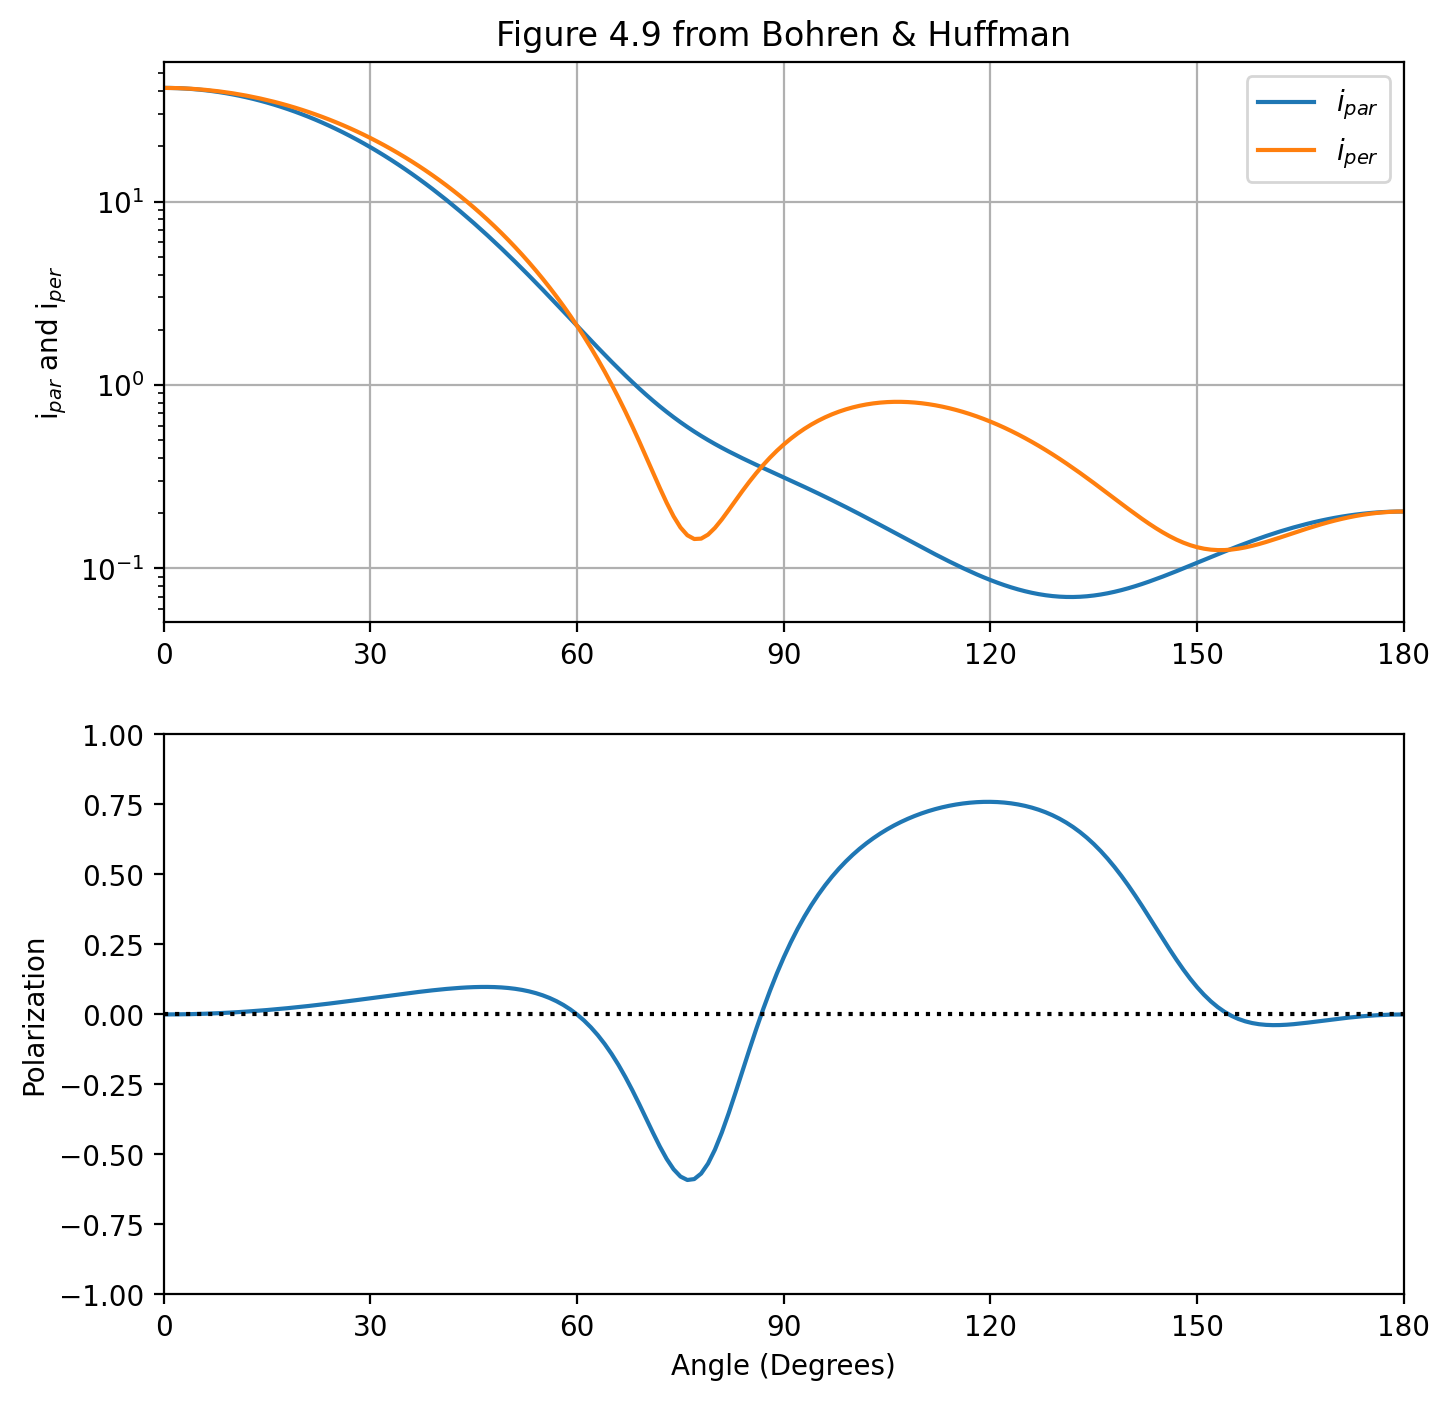

In [10]:
x = 3
m = 1.33 - 1e-8j

theta = np.linspace(0, 180, 181)
mu = np.cos(theta * np.pi / 180)

scaling_factor = 1 / 4
iper = scaling_factor * mie.i_per(m, x, mu, "bohren")
ipar = scaling_factor * mie.i_par(m, x, mu, "bohren")

P = (iper - ipar) / (iper + ipar)

plt.subplots(2, 1, figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.semilogy(theta, ipar, label="$i_{par}$")
plt.semilogy(theta, iper, label="$i_{per}$")
plt.xlim(0, 180)
plt.xticks(range(0, 181, 30))
plt.ylabel("i$_{par}$ and i$_{per}$")
plt.legend()
plt.grid(True)
plt.title("Figure 4.9 from Bohren & Huffman")
plt.subplot(2, 1, 2)
plt.plot(theta, P)
plt.ylim(-1, 1)
plt.xticks(range(0, 181, 30))
plt.xlim(0, 180)
plt.ylabel("Polarization")
plt.plot([0, 180], [0, 0], ":k")
plt.xlabel("Angle (Degrees)")
plt.show()

## Comparison to PyMieScatt

This package evidently uses Wiscombe's normalization. 
    
    import PyMieScatt
    
    print(PyMieScatt.MieS1S2(1.5,0.02,0.75))
    print(mie.mie_S1_S2(1.5,0.02,0.75,norm='wiscombe'))

produces::

    ((3.690888119953865e-12-2.353141061130335e-06j), (2.7681660899653986e-12-1.7648752402921955e-06j))
    ((3.690978962673683e-12+2.3531410334006517e-06j), (2.7682310595192753e-12+1.7648752220853264e-06j))